# Prompt-Guided Defect Detection Pipeline

This notebook runs the complete pipeline for defect detection using Qwen-VL on MVTec AD dataset.

**Requirements:**
- MVTec AD dataset & scripts uploaded to Google Drive


Output files:
- `defect_dataset.jsonl` - Dataset in JSONL format
- `defect_results.json` - Full results with all metadata
- `evaluation_results.json` - METEOR & SPICE scores
- `annotated/` folder - Images with red contours

## 1. Setup Environment

In [ ]:
# Kaggle Environment Setup
# Replace YOUR_GITHUB_USERNAME and YOUR_REPO_NAME with your actual GitHub info

import os
import sys

# Configuration
GITHUB_REPO = "https://github.com/YOUR_GITHUB_USERNAME/YOUR_REPO_NAME.git"
REPO_NAME = "YOUR_REPO_NAME"  # Just the repo name, e.g., 'defect-detection'
WORK_DIR = "/kaggle/working"

# Clone repository
print("Cloning GitHub repository...")
!git clone {GITHUB_REPO}

# Add to Python path
repo_path = os.path.join(WORK_DIR, REPO_NAME)
if repo_path not in sys.path:
    sys.path.insert(0, repo_path)

print(f"Repository cloned to: {repo_path}")
print(f"Added to Python path: {repo_path}")

In [ ]:
# Install Required Packages
print("Installing dependencies...")

# Install from requirements.txt if it exists
requirements_path = os.path.join(repo_path, "requirements.txt")
if os.path.exists(requirements_path):
    !pip install -q -r {requirements_path}
else:
    # Manual installation
    !pip install -q transformers>=4.45.0
    !pip install -q accelerate>=0.25.0
    !pip install -q qwen-vl-utils
    !pip install -q opencv-python-headless
    !pip install -q pillow
    !pip install -q tqdm
    !pip install -q matplotlib
    # Optional: pycocoevalcap for official metrics
    # !pip install -q pycocoevalcap

print("Dependencies installed!")

In [ ]:
# Setup Directories and Verify Imports
import os

# Change to repository directory
os.chdir(repo_path)
print(f"Working directory: {os.getcwd()}")

# Create output directory
OUTPUT_DIR = os.path.join(WORK_DIR, "output")
os.makedirs(OUTPUT_DIR, exist_ok=True)
print(f"Output directory: {OUTPUT_DIR}")

# Verify imports
print("\nVerifying imports...")
try:
    from data_processing import load_mvtec_dataset
    from visual_prompting import batch_process_images
    from qwen_vl_inference import batch_inference_optimized
    from evaluation import evaluate_all, create_ground_truth
    from text_visualization import save_generated_text, visualize_results
    print("All modules imported successfully!")
except ImportError as e:
    print(f"Import error: {e}")
    print("Please check that all Python files are in the repository.")

## Dataset Setup

### Option 1: Add MVTec-AD Dataset
1. Go to Kaggle Datasets: https://www.kaggle.com/datasets/
2. Search for "MVTec AD" or upload your own
3. Click "Add Data" in this notebook
4. Dataset will be available at `/kaggle/input/mvtec-ad/`

### Option 2: Download from Google Drive
```python
# Uncomment if using Drive
# from google_drive_downloader import GoogleDriveDownloader as gdd
# gdd.download_file_from_google_drive(
#     file_id='YOUR_FILE_ID',
#     dest_path='/kaggle/working/mvtec_ad.tar.xz',
#     unzip=True
# )
```

### Set Dataset Path
After adding dataset, set the path in next cell.

In [ ]:
# Set MVTec-AD Dataset Path
# Update this path based on where your dataset is located in Kaggle

MVTEC_ROOT = "/kaggle/input/mvtec-ad/"  # Adjust this path

# Verify dataset exists
if os.path.exists(MVTEC_ROOT):
    print(f"Dataset found at: {MVTEC_ROOT}")
    # List categories
    categories = [d for d in os.listdir(MVTEC_ROOT) if os.path.isdir(os.path.join(MVTEC_ROOT, d))]
    print(f"Categories found: {len(categories)}")
    print(f"Categories: {', '.join(sorted(categories)[:5])}...")
else:
    print(f"ERROR: Dataset not found at {MVTEC_ROOT}")
    print("Please add the MVTec-AD dataset to this notebook.")

In [ ]:
!pip install -q transformers>=4.45.0 accelerate>=0.25.0 qwen-vl-utils
!pip install -q opencv-python-headless pillow tqdm

In [ ]:
# Check GPU
import torch
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

CUDA available: True
GPU: Tesla T4
Memory: 15.8 GB


In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Set paths
MVTEC_ROOT = "/content/drive/MyDrive/AIP491/MVTEC-AD"
OUTPUT_DIR = "/content/output"
SCRIPTS_DIR = "/content/drive/MyDrive/AIP491/scripts"

import sys
sys.path.insert(0, SCRIPTS_DIR)

## 2. Load and Process Dataset

In [ ]:
from data_processing import load_mvtec_dataset, process_mask_to_bbox_and_location
import cv2
import os
from collections import Counter

# Load dataset
dataset = load_mvtec_dataset(MVTEC_ROOT, include_good=True)
print(f"Found {len(dataset)} samples")

# Separate samples into good (no defects) and defective
good_samples = [item for item in dataset if item.get('is_good', False)]
defective_samples = [item for item in dataset if not item.get('is_good', False)]

# Count good and defective samples
good_count = len(good_samples)
defective_count = len(defective_samples)

# Show distribution
categories_good = Counter(item['category'] for item in good_samples)
categories_defective = Counter(item['category'] for item in defective_samples)


print(f"\nTotal good samples: {good_count}")
print(f"Total defective samples: {defective_count}")
print(f"Total samples: {good_count + defective_count}")

print("\nSamples by category (No Defects):")
for cat, count in sorted(categories_good.items()):
    print(f"  {cat}: {count}")

print("\nSamples by category (Defective):")
for cat, count in sorted(categories_defective.items()):
    print(f"  {cat}: {count}")


Found 1725 samples

Total good samples: 467
Total defective samples: 1258
Total samples: 1725

Samples by category (No Defects):
  bottle: 20
  cable: 58
  capsule: 23
  carpet: 28
  grid: 21
  hazelnut: 40
  leather: 32
  metal_nut: 22
  pill: 26
  screw: 41
  tile: 33
  toothbrush: 12
  transistor: 60
  wood: 19
  zipper: 32

Samples by category (Defective):
  bottle: 63
  cable: 92
  capsule: 109
  carpet: 89
  grid: 57
  hazelnut: 70
  leather: 92
  metal_nut: 93
  pill: 141
  screw: 119
  tile: 84
  toothbrush: 30
  transistor: 40
  wood: 60
  zipper: 119


In [ ]:
# Limit samples for testing
# LIMIT = None
# if LIMIT:
#     dataset = dataset[:LIMIT]
#     print(f"Limited to {LIMIT} samples")

## 3. Visual Prompting - Draw Red Contours

In [ ]:
from visual_prompting import draw_defect_contour
from tqdm import tqdm
processed_results = []
annotated_dir = os.path.join(OUTPUT_DIR, "annotated")
for item in tqdm(dataset, desc="Processing images"):
    try:
        # Check if this is a good (no defect) or defective image
        if item.get('is_good') or item['mask_path'] is None:
            # GOOD IMAGE - No annotation needed
            result = {
                'original_path': item['image_path'],
                'annotated_path': item['image_path'],  # Use original image
                'mask_path': None,
                'category': item['category'],
                'defect_type': 'good',
                'image_name': item['image_name'],
                'bboxes': [],
                'combined_bbox': None,
                'location': None
            }
            processed_results.append(result)

        else:
            # DEFECTIVE IMAGE - Draw contour and extract bbox
            image = cv2.imread(item['image_path'])
            mask = cv2.imread(item['mask_path'], cv2.IMREAD_GRAYSCALE)

            if image is None or mask is None:
                continue

            h, w = image.shape[:2]

            # Get bbox and location
            bbox_info = process_mask_to_bbox_and_location(item['mask_path'], (w, h))

            # Draw red contour
            annotated = draw_defect_contour(image, mask)

            # Save annotated image
            cat_dir = os.path.join(annotated_dir, item['category'], item['defect_type'])
            os.makedirs(cat_dir, exist_ok=True)
            output_path = os.path.join(cat_dir, f"{item['image_name']}_annotated.png")
            cv2.imwrite(output_path, annotated)

            # Store result
            result = {
                'original_path': item['image_path'],
                'annotated_path': output_path,
                'mask_path': item['mask_path'],
                'category': item['category'],
                'defect_type': item['defect_type'],
                'image_name': item['image_name'],
                'bboxes': bbox_info['bboxes'],
                'combined_bbox': bbox_info['combined_bbox'],
                'location': bbox_info['location']
            }
            processed_results.append(result)

    except Exception as e:
        print(f"Error: {item['image_path']}: {e}")
# Verify counts
good_count = sum(1 for r in processed_results if r.get('defect_type') == 'good')
defective_count = sum(1 for r in processed_results if r.get('defect_type') != 'good')
print(f"\n Processed {len(processed_results)} images")
print(f"   Good: {good_count}")
print(f"   Defective: {defective_count}")

Processing images: 100%|██████████| 1725/1725 [16:51<00:00,  1.71it/s]


 Processed 1725 images
   Good: 467
   Defective: 1258


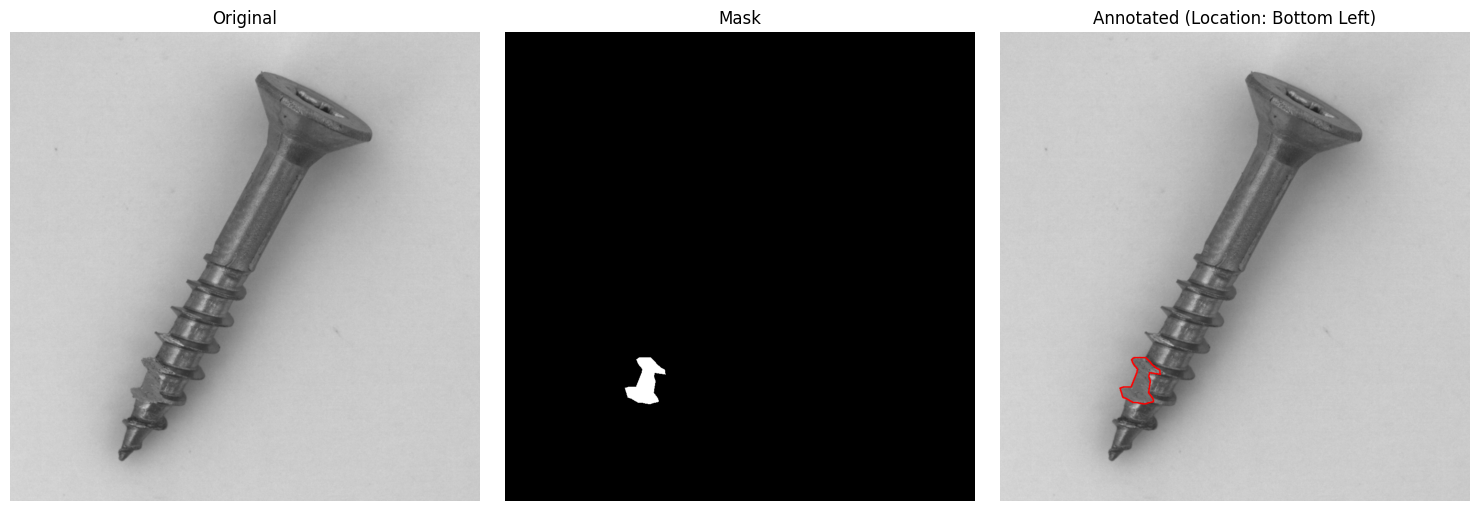

Category: screw
Defect Type: thread_top
Bounding Box: (261, 711, 350, 813)
Location: Bottom Left


In [ ]:
# Visualize a sample
import matplotlib.pyplot as plt

if processed_results:
    sample = processed_results[1111]

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Original
    img_orig = cv2.imread(sample['original_path'])
    img_orig = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)
    axes[0].imshow(img_orig)
    axes[0].set_title('Original')
    axes[0].axis('off')

    # Mask
    mask = cv2.imread(sample['mask_path'], cv2.IMREAD_GRAYSCALE)
    axes[1].imshow(mask, cmap='gray')
    axes[1].set_title('Mask')
    axes[1].axis('off')

    # Annotated
    img_ann = cv2.imread(sample['annotated_path'])
    img_ann = cv2.cvtColor(img_ann, cv2.COLOR_BGR2RGB)
    axes[2].imshow(img_ann)
    axes[2].set_title(f"Annotated (Location: {sample['location']})")
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

    print(f"Category: {sample['category']}")
    print(f"Defect Type: {sample['defect_type']}")
    print(f"Bounding Box: {sample['combined_bbox']}")
    print(f"Location: {sample['location']}")

## 4. Qwen-VL Inference

In [ ]:
from qwen_vl_inference import load_qwen2_vl_model
model, processor = load_qwen2_vl_model("Qwen/Qwen2-VL-2B-Instruct")
print(f"Model loaded on: {next(model.parameters()).device}")

Loading Qwen/Qwen2-VL-2B-Instruct...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/729 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/272 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/347 [00:00<?, ?B/s]

chat_template.json: 0.00B [00:00, ?B/s]

The image processor of type `Qwen2VLImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. 


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Model loaded successfully! Device: cuda:0
Model loaded on: cuda:0


In [ ]:
from qwen_vl_inference import describe_defect_with_location, describe_product_for_defects

for item in tqdm(processed_results, desc="Generating descriptions"):
    try:
        category = item.get('category', 'product')

        # Check if good or defective
        if item.get('defect_type') == 'good':
            # GOOD IMAGE
            description = describe_product_for_defects(
                item['original_path'],  # Use original path
                model,
                processor,
                category=category,
                max_tokens=100,
                temperature=0.1
            )
        else:
            # DEFECTIVE IMAGE - Describe defect with location
            description = describe_defect_with_location(
                item['annotated_path'],  # Use annotated path
                model,
                processor,
                location=item.get('location', 'Center'),
                category=category,
                max_tokens=100,
                temperature=0.1
            )

        item['generated_text'] = description

    except Exception as e:
        print(f"Error: {e}")
        item['generated_text'] = f"Error: {str(e)}"

Generating descriptions: 100%|██████████| 1725/1725 [1:04:03<00:00,  2.23s/it]


In [ ]:
good = [r for r in processed_results if r.get('defect_type') == 'good']
defective = [r for r in processed_results if r.get('defect_type') != 'good']
print(f"Total: {len(processed_results)}")
print(f"Good: {len(good)}")
print(f"Defective: {len(defective)}")
print("\nGood sample outputs:")
for r in good[:-15]:
    print(f"  {r['category']}: {r.get('generated_text', 'NO TEXT')}")
print("\nDefective sample outputs:")
for r in defective[:-15]:
    print(f"  {r['category']}: {r.get('generated_text', 'NO TEXT')}...")

Total: 1725
Good: 467
Defective: 1258

Good sample outputs:
  bottle: Bottle has a defect at the bottom.
  bottle: Bottle has a defect at the bottom.
  bottle: Bottle has a defect at the bottom.
  bottle: Bottle has a defect at the bottom.
  bottle: Bottle has a defect at the bottom.
  bottle: Bottle has a defect at the bottom.
  bottle: Bottle has a defect at the bottom.
  bottle: Bottle has a defect at the bottom.
  bottle: Bottle has a defect at the bottom.
  bottle: Bottle has a defect at the bottom.
  bottle: Bottle has a defect at the bottom.
  bottle: Bottle has a defect at the bottom.
  bottle: Bottle has a defect at the bottom.
  bottle: Bottle has a defect at the bottom.
  bottle: Bottle has a defect at the bottom.
  bottle: Bottle has a defect at the bottom.
  bottle: Bottle has a defect at the bottom.
  bottle: Bottle has a defect at the bottom.
  bottle: Bottle has a defect at the bottom.
  bottle: Bottle has a defect at the bottom.
  cable: Cable has a copper conductor de

In [ ]:
# Show sample results
for i, item in enumerate(processed_results[:15]):
    print(f"\n--- Sample {i+1} ---")
    print(f"Category: {item['category']}")
    print(f"Defect: {item['defect_type']}")
    print(f"Location: {item['location']}")
    print(f"Generated: {item.get('generated_text', 'N/A')}...")


--- Sample 1 ---
Category: bottle
Defect: broken_large
Location: Center
Generated: This is a bottle with a small crack at the center....

--- Sample 2 ---
Category: bottle
Defect: broken_large
Location: Center
Generated: This is a bottle with a small crack at the center....

--- Sample 3 ---
Category: bottle
Defect: broken_large
Location: Center
Generated: This is a bottle with a small crack at the center....

--- Sample 4 ---
Category: bottle
Defect: broken_large
Location: Right
Generated: "This is a bottle with a small crack at the bottom-right."...

--- Sample 5 ---
Category: bottle
Defect: broken_large
Location: Center
Generated: This is a bottle with a small crack at the center....

--- Sample 6 ---
Category: bottle
Defect: broken_large
Location: Center
Generated: "This is a bottle with a [size] [defect type] at the [location]."...

--- Sample 7 ---
Category: bottle
Defect: broken_large
Location: Center
Generated: "This is a bottle with a [size] [defect type] at the [location].".

## 5. Evaluation

In [ ]:
from evaluation import evaluate_all, create_ground_truth
# Run evaluation
eval_results = evaluate_all(
    processed_results,
    use_location=True,
    use_standard_metrics=True  # Set to True if pycocoevalcap is installed
)
print("EVALUATION RESULTS")
print("-"*60)
summary = eval_results.get('summary', {})
print(f"\nAttribute Accuracy:")
print(f"Defect Type: {summary.get('defect_type_accuracy', 0):.3f}")
print(f"Location: {summary.get('location_accuracy', 0):.3f}")
print(f"Size: {summary.get('size_accuracy', 0):.3f}")
# Text quality metrics (if available)
if 'text_quality' in eval_results:
    metrics = eval_results['text_quality'].get('metrics', {})
    print(f"\nText Quality Metrics:")
    if 'METEOR' in metrics:
        print(f"  METEOR: {metrics['METEOR']:.4f}")
    if 'SPICE' in metrics:
        print(f"  SPICE: {metrics['SPICE']:.4f}")

EVALUATION RESULTS
------------------------------------------------------------

Attribute Accuracy:
Defect Type: 0.457
Location: 0.723
Size: 0.000

Text Quality Metrics:
  METEOR: 0.6380
  SPICE: 0.4103


## 6. Export Results

In [ ]:
from dataset_export import export_to_jsonl, export_to_json, generate_statistics
import json

# Export JSONL
jsonl_path = os.path.join(OUTPUT_DIR, "defect_dataset.jsonl")
export_to_jsonl(processed_results, jsonl_path)

# Export JSON
json_path = os.path.join(OUTPUT_DIR, "defect_results.json")
export_to_json(processed_results, json_path)

# Save evaluation
eval_path = os.path.join(OUTPUT_DIR, "evaluation_results.json")
with open(eval_path, 'w') as f:
    json.dump(eval_results, f, indent=2)
print(f"Saved evaluation to {eval_path}")

# Statistics
stats = generate_statistics(processed_results)
print(f"\nDataset Statistics:")
print(f"  Total samples: {stats['total_samples']}")
print(f"  Categories: {len(stats['categories'])}")
print(f"  Defect types: {len(stats['defect_types'])}")

Exported 1725 records to /content/output/defect_dataset.jsonl
Exported 1725 records to /content/output/defect_results.json
Saved evaluation to /content/output/evaluation_results.json

Dataset Statistics:
  Total samples: 1725
  Categories: 15
  Defect types: 49


### Download Annotated Images

In [ ]:
import shutil
import os
from google.colab import files

# Define the path to the annotated directory
annotated_dir = os.path.join(OUTPUT_DIR, "annotated")

# Define the path for the zip file
zip_filename = os.path.join(OUTPUT_DIR, "annotated_images.zip")

# Create a zip archive of the annotated directory
print(f"Creating zip archive of {annotated_dir}...")
shutil.make_archive(zip_filename.replace('.zip', ''), 'zip', annotated_dir)
print(f"Zip archive created at {zip_filename}")

# Download the zip file
files.download(zip_filename)

Creating zip archive of /content/output/annotated...
Zip archive created at /content/output/annotated_images.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Download results (optional)
from google.colab import files

# Uncomment to download
files.download(jsonl_path)
files.download(eval_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Import Text Visualization Module
from text_visualization import (
    save_generated_text,
    visualize_results,
    visualize_by_category,
    compare_defect_vs_normal
)

In [ ]:
# Save Generated Text to Folder
print("\n" + "="*70)
print("Saving Generated Text Descriptions")
print("="*70)

metadata = save_generated_text(
    results=results,
    output_dir=OUTPUT_DIR,
    text_folder="generated_text"
)

print(f"\nSaved {metadata['total_saved']} text descriptions!")
print(f"Location: {metadata['output_dir']}")

In [ ]:
# Display Statistics
print("\n" + "="*70)
print("Generated Text Statistics")
print("="*70)

total = len(results)
with_text = sum(1 for r in results if 'generated_text' in r and r['generated_text'])
defects = sum(1 for r in results if r.get('defect_type') != 'good' and 'generated_text' in r)
normal = sum(1 for r in results if r.get('defect_type') == 'good' and 'generated_text' in r)

print(f"\nTotal samples: {total}")
print(f"  With generated text: {with_text}")
print(f"  Defective images: {defects}")
print(f"  Normal images: {normal}")

# Show sample texts
print("\nSample Generated Texts:")
print("-"*70)
sample_count = 0
for result in results:
    if 'generated_text' in result and result['generated_text']:
        category = result.get('category', 'Unknown')
        defect_type = result.get('defect_type', 'Unknown')
        text = result.get('generated_text', '')
        location = result.get('location', 'N/A')
        
        print(f"\n{sample_count + 1}. [{category} | {defect_type} | {location}]")
        print(f'   "{text}"')
        
        sample_count += 1
        if sample_count >= 5:
            break

In [ ]:
# Visualize Results with Generated Text
print("\n" + "="*70)
print("Visualizing Results with Generated Text")
print("="*70)

visualize_results(
    results=results,
    num_samples=6,
    cols=2,
    figsize=(15, 12),
    show_metadata=True,
    save_path=os.path.join(OUTPUT_DIR, "visualization_samples.png")
)

print(f"\nVisualization saved to: {os.path.join(OUTPUT_DIR, 'visualization_samples.png')}")

In [ ]:
# Compare Defect vs Normal Images
print("\n" + "="*70)
print("Defect vs Normal Comparison")
print("="*70)

compare_defect_vs_normal(
    results=results,
    category=None,
    defect_samples=3,
    normal_samples=3,
    figsize=(15, 10)
)

In [ ]:
# Display and Save Evaluation Metrics
print("\n" + "="*70)
print("Evaluation Metrics Summary")
print("="*70)

# Display attribute accuracy
if 'attribute_accuracy' in eval_results:
    print("\n[1] ATTRIBUTE-LEVEL ACCURACY:")
    print("-"*70)
    attr_metrics = eval_results['attribute_accuracy']
    print(f"   Defect Type Accuracy: {attr_metrics['defect_type_accuracy']:.2%}")
    print(f"   Size Accuracy:        {attr_metrics['size_accuracy']:.2%}")
    print(f"   Location Accuracy:    {attr_metrics['location_accuracy']:.2%}")
    print(f"   Total Samples:        {attr_metrics['total_samples']}")

# Display text quality metrics
if 'text_quality' in eval_results:
    print("\n[2] TEXT QUALITY METRICS:")
    print("-"*70)
    quality_metrics = eval_results['text_quality'].get('metrics', {})
    method = eval_results['text_quality'].get('method', 'unknown')
    comparable = eval_results['text_quality'].get('comparable_with_papers', False)
    
    print(f"   Method: {method}")
    print(f"   Comparable with papers: {'Yes' if comparable else 'No'}")
    print()
    
    for metric_name, value in quality_metrics.items():
        if value is not None:
            if isinstance(value, (int, float)):
                print(f"   {metric_name:15s}: {value:.4f}")
            else:
                print(f"   {metric_name:15s}: {value}")

# Save metrics to JSON
import json
metrics_file = os.path.join(OUTPUT_DIR, "evaluation_metrics.json")
with open(metrics_file, 'w', encoding='utf-8') as f:
    json.dump(eval_results, f, indent=2, ensure_ascii=False)

print(f"\nMetrics saved to: {metrics_file}")

In [ ]:
# Summary of All Saved Files
print("\n" + "="*70)
print("Summary of Saved Files")
print("="*70)

saved_files = {
    "Generated Text": os.path.join(OUTPUT_DIR, "generated_text/"),
    "Annotated Images": os.path.join(OUTPUT_DIR, "annotated_images/"),
    "Visualization": os.path.join(OUTPUT_DIR, "visualization_samples.png"),
    "Evaluation Metrics": os.path.join(OUTPUT_DIR, "evaluation_metrics.json"),
    "Inference Results": os.path.join(OUTPUT_DIR, "inference_results.json")
}

for name, path in saved_files.items():
    exists = "[OK]" if os.path.exists(path) else "[--]"
    print(f"{exists} {name:20s}: {path}")

print(f"\nAll results saved successfully!")
print("="*70)